Forcing all operations to use device: cpu
✅ Setup complete. Model loaded on cpu.


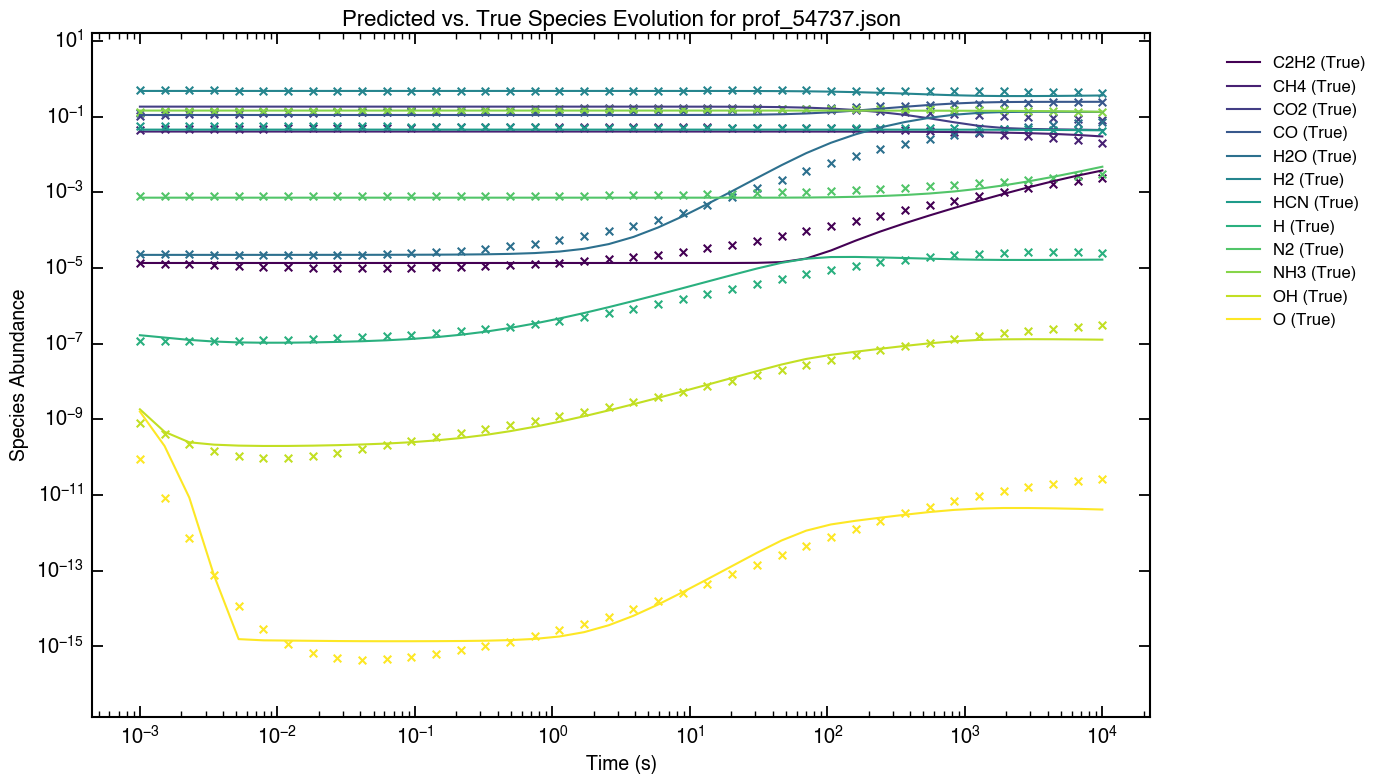

In [5]:
import json
import random
import sys
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np

# Add project source to path
project_root = Path.cwd().parent
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
from normalizer import DataNormalizer
from utils import load_config

plt.style.use('science.mplstyle')

# %%
# 2. LOAD ARTIFACTS
# --- Paths ---
CONFIG_FILE = project_root / "inputs/model_input_params.jsonc"
DATA_ROOT = project_root / "data"
config = load_config(CONFIG_FILE)
model_folder = DATA_ROOT / config["output_paths_config"]["fixed_model_foldername"]
normalized_data_folder = DATA_ROOT / config["data_paths_config"]["normalized_profiles_foldername"]
raw_data_folder = DATA_ROOT / config["data_paths_config"]["raw_profiles_foldername"]

# --- Load Model, Metadata, and Test Set list ---
# ============================ SIMPLE CPU FIX: START ============================
# Force everything to run on the CPU for maximum simplicity and portability.
device = torch.device("cpu")
print(f"Forcing all operations to use device: {device}")
# ============================= SIMPLE CPU FIX: END =============================

model = torch.jit.load(model_folder / "best_model_jit.pt", map_location=device)
model.eval()
with (normalized_data_folder / "normalization_metadata.json").open("r") as f:
    norm_metadata = json.load(f)
with (model_folder / "test_set_info.json").open("r") as f:
    test_filenames = json.load(f)["test_filenames"]

# --- Get variable lists from config ---
species_vars = sorted(config["species_variables"])
global_vars = sorted(config["global_variables"])
species_labels = [s.replace('_evolution', '') for s in species_vars]

print(f"✅ Setup complete. Model loaded on {device}.")

# %%
# 3. PREDICT AND PLOT FOR A SINGLE TEST PROFILE

# --- Select a random test file and load both versions ---
test_filename = random.choice(test_filenames)
with (normalized_data_folder / test_filename).open("r") as f:
    norm_profile = json.load(f)
with (raw_data_folder / test_filename).open("r") as f:
    raw_profile = json.load(f)

# --- Prepare the constant part of the input vector ---
initial_species = [norm_profile[key][0] for key in species_vars]
global_conds = [norm_profile[key] for key in global_vars]
base_input = torch.tensor(initial_species + global_conds, dtype=torch.float32)

# --- Predict for every time step in the profile ---
predicted_evolutions_norm = []
for norm_time_step in norm_profile["t_time"]:
    time_tensor = torch.tensor([norm_time_step], dtype=torch.float32)
    
    # All tensors are created on the CPU by default, and the model is on the CPU,
    # so no .to(device) call is needed here.
    input_vector = torch.cat([base_input, time_tensor]).unsqueeze(0)
    
    with torch.no_grad():
        # Model is on CPU, input is on CPU, so output will be on CPU.
        # No .cpu() call is needed on the result.
        norm_pred = model(input_vector).squeeze(0)
        predicted_evolutions_norm.append(norm_pred)

# --- Stack and Denormalize All Predictions at Once ---
predicted_evolutions_norm = torch.stack(predicted_evolutions_norm)
predicted_evolutions_norm = predicted_evolutions_norm.T

predicted_evolutions_denorm = []
for i, key in enumerate(species_vars):
    series_tensor = predicted_evolutions_norm[i]
    denorm_series = DataNormalizer.denormalize(series_tensor, norm_metadata, key)
    predicted_evolutions_denorm.append(denorm_series.numpy())

raw_times = raw_profile['t_time']

# --- Plot the results ---
fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(species_vars)))

for i, key in enumerate(species_vars):
    ax.plot(raw_times, raw_profile[key], color=colors[i], label=species_labels[i] + " (True)")
    ax.scatter(raw_times, predicted_evolutions_denorm[i], color=colors[i], marker='x', s=30)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Time (s)", fontsize=14)
ax.set_ylabel("Species Abundance", fontsize=14)
ax.set_title(f"Predicted vs. True Species Evolution for {test_filename}", fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#ax.set_ylim(1e-20, 2)
plt.tight_layout()
plt.show()

In [6]:
import json
import random
import sys
import time
from pathlib import Path
import torch
import numpy as np
import pandas as pd

# --- Setup: Add project source to the Python path ---
project_root = Path.cwd().parent
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    
from utils import load_config
from normalizer import DataNormalizer

def print_header(title: str):
    """Prints a formatted, centered header to the console."""
    width = 80
    padding = (width - len(title) - 2) // 2
    print("\n" + "=" * width)
    print(" " * padding, title, " " * padding)
    print("=" * width)

def prepare_batch_for_benchmark(batch_size: int, test_filenames: list, norm_data_folder: Path, species_vars: list, global_vars: list, device: torch.device):
    """
    Creates a batch of input tensors for benchmarking.
    Each item corresponds to the final time step of a randomly chosen test profile.
    """
    batch_inputs = []
    for _ in range(batch_size):
        test_filename = random.choice(test_filenames)
        with (norm_data_folder / test_filename).open("r") as f:
            norm_profile = json.load(f)
        initial_species = [norm_profile[key][0] for key in species_vars]
        global_conds = [norm_profile[key] for key in global_vars]
        final_norm_time = norm_profile["t_time"][-1]
        input_vector = torch.tensor(initial_species + global_conds + [final_norm_time], dtype=torch.float32)
        batch_inputs.append(input_vector)
    # The .to(device) call is still here, but 'device' will always be 'cpu'.
    return torch.stack(batch_inputs).to(device)


def run_benchmark_and_validate():
    """
    Main function to load artifacts, run a performance benchmark, and then
    validate a single prediction with detailed output.
    """
    # 1. LOAD ARTIFACTS
    # --------------------------------------------------------------------------
    print_header("Initialization")
    print("Loading model and configuration artifacts...")
    CONFIG_FILE = project_root / "inputs/model_input_params.jsonc"
    DATA_ROOT = project_root / "data"
    
    config = load_config(CONFIG_FILE)
    if not config: print("Error: Could not load configuration. Exiting."); return
        
    model_folder = DATA_ROOT / config["output_paths_config"]["fixed_model_foldername"]
    normalized_data_folder = DATA_ROOT / config["data_paths_config"]["normalized_profiles_foldername"]

    # ============================ SIMPLE CPU FIX: START ============================
    # Force everything to run on the CPU for maximum simplicity and portability.
    device = torch.device("cpu")
    # ============================= SIMPLE CPU FIX: END =============================
    
    model_path = model_folder / "best_model_jit.pt"
    if not model_path.exists(): print(f"Error: Model file not found at {model_path}. Exiting."); return

    model = torch.jit.load(model_path, map_location=device)
    model.eval()
    
    norm_meta_path = normalized_data_folder / "normalization_metadata.json"
    if not norm_meta_path.exists(): print(f"Error: Normalization metadata not found at {norm_meta_path}. Exiting."); return
    with norm_meta_path.open("r") as f:
        norm_metadata = json.load(f)

    test_info_path = model_folder / "test_set_info.json"
    if not test_info_path.exists(): print(f"Error: Test set info file not found at {test_info_path}. Exiting."); return
    with test_info_path.open("r") as f:
        test_filenames = json.load(f)["test_filenames"]

    species_vars = sorted(config["species_variables"])
    global_vars = sorted(config["global_variables"])
    print(f"Setup complete. Model loaded on device: {device.type.upper()}")
    
    # 2. RUN PERFORMANCE BENCHMARK
    # --------------------------------------------------------------------------
    print_header("Performance Benchmark")
    BATCH_SIZE = 512
    NUM_WARMUP_RUNS = 5
    NUM_TIMING_RUNS = 20

    batch_tensor = prepare_batch_for_benchmark(BATCH_SIZE, test_filenames, normalized_data_folder, species_vars, global_vars, device)
    
    # --- CPU Warmup ---
    with torch.no_grad():
        for _ in range(NUM_WARMUP_RUNS):
            _ = model(batch_tensor)
    
    # --- Timed Runs ---
    timings = []
    with torch.no_grad():
        for _ in range(NUM_TIMING_RUNS):
            start_time = time.perf_counter()
            _ = model(batch_tensor)
            end_time = time.perf_counter()
            timings.append(end_time - start_time)

    # 3. REPORT BENCHMARK RESULTS
    # --------------------------------------------------------------------------
    total_time = sum(timings)
    avg_batch_time_ms = (total_time / NUM_TIMING_RUNS) * 1000
    avg_prediction_time_us = (avg_batch_time_ms / BATCH_SIZE) * 1000

    print(f"{'Batch Size:':<28} {BATCH_SIZE}")
    print(f"{'Device:':<28} {device.type.upper()}")
    print(f"{'Average time per batch:':<28} {avg_batch_time_ms:.4f} ms")
    print(f"{'Average time per single pred:':<28} {avg_prediction_time_us:.4f} µs (microseconds)")

    # 4. RUN SINGLE PREDICTION VALIDATION
    # --------------------------------------------------------------------------
    print_header("Single Prediction Validation")
    test_filename = random.choice(test_filenames)
    print(f"  - Using profile: {test_filename}")
    with (normalized_data_folder / test_filename).open("r") as f:
        norm_profile = json.load(f)
        
    query_time_idx = random.randint(1, len(norm_profile["t_time"]) - 1)
    norm_time_to_predict = norm_profile["t_time"][query_time_idx]
    real_time_to_predict = DataNormalizer.denormalize(norm_time_to_predict, norm_metadata, "t_time")
    print(f"  - Predicting at time index {query_time_idx} (t ≈ {real_time_to_predict:.4e} s)")
    
    initial_species = [norm_profile[key][0] for key in species_vars]
    global_conds = [norm_profile[key] for key in global_vars]
    
    # All tensors created on CPU by default, model is on CPU, no device movement needed.
    input_vector = torch.tensor(
        initial_species + global_conds + [norm_time_to_predict], dtype=torch.float32
    ).unsqueeze(0)
    
    with torch.no_grad():
        # Output is already on CPU.
        norm_prediction_tensor = model(input_vector).squeeze(0)

    norm_true_values_tensor = torch.tensor([norm_profile[key][query_time_idx] for key in species_vars])
    
    # 5. DENORMALIZE AND REPORT VALIDATION RESULTS
    # --------------------------------------------------------------------------
    results = []
    for i, key in enumerate(species_vars):
        predicted_val = DataNormalizer.denormalize(norm_prediction_tensor[i], norm_metadata, key).item()
        true_val = DataNormalizer.denormalize(norm_true_values_tensor[i], norm_metadata, key).item()
        
        results.append({
            "Species": key.replace('_evolution', ''),
            "Predicted Value": predicted_val,
            "True Value": true_val,
            "Abs. Error": abs(predicted_val - true_val),
            "Rel. Error (%)": abs(predicted_val - true_val) / (true_val + 1e-20) * 100
        })

    df = pd.DataFrame(results)
    
    pd.options.display.float_format = '{:,.4e}'.format
    
    print("\n" + df.to_string(index=False))
    print("-" * 80 + "\n")


if __name__ == "__main__":
    run_benchmark_and_validate()


                                 Initialization                                 
Loading model and configuration artifacts...
Setup complete. Model loaded on device: CPU

                             Performance Benchmark                             
Batch Size:                  512
Device:                      CPU
Average time per batch:      3.5954 ms
Average time per single pred: 7.0223 µs (microseconds)

                          Single Prediction Validation                          
  - Using profile: prof_5094.json
  - Predicting at time index 24 (t ≈ 2.0309e+01 s)

Species  Predicted Value  True Value  Abs. Error  Rel. Error (%)
   C2H2       6.2945e-04  4.0438e-04  2.2507e-04      5.5658e+01
    CH4       2.1333e-01  2.1454e-01  1.2111e-03      5.6450e-01
    CO2       4.3054e-03  3.1306e-03  1.1748e-03      3.7528e+01
     CO       1.2179e-04  1.6054e-04  3.8745e-05      2.4135e+01
    H2O       3.4856e-02  3.6491e-02  1.6348e-03      4.4801e+00
     H2       5.6376e-01  5.34